# Part One

This puzzle is a dependancy graph. We should build the graph, then walk it to determine the order.

I'm thinking of a recursive algorithm, starting with the steps with no dependents. For each set of steps at the same level (starting with the bottom), (1) add them to the front of the resolution order in alphabetical order, (2) build their dependancy graphs seperately, then (3) merge each of these graphs and add them to the resolution order. The 2nd step is the recursive part. This may not work, I've just thought it up now.

In [1]:
import graphviz

class DepGraph:
    def __init__(self):
        '''Sets up internal representations'''
        self._graph = {}
        self._roots = None
        self._leaves = None
    
    def add(self, dependency, dependant):
        '''Adds a relationship to the graph.'''
        self._graph.setdefault(dependant, []).append(dependency)
        self._graph[dependant].sort()
    
    def __getitem__(self, key):
        return self._graph.setdefault(key, [])
    
    def roots(self):
        '''Returns a tuple of the graphs roots, that is nodes with no dependants'''
        if not self._roots:
            self._roots = []
            for node in self._graph:
                root = True
                for edges in self._graph.values():
                    if node in edges:
                        root = False
                        break
                if root:
                    self._roots.append(node)
            self._roots = tuple(self._roots)
        return self._roots
    
    def visualise(self):
        dot = graphviz.Digraph(comment="Day 7")
        for node, deps in self._graph.items():
            dot.node(node, node)
            for dep in deps:
                dot.edge(node, dep)
        return dot
            

In [2]:
import re

def read_input(filename):
    with open(filename) as instructions:
        instructions = instructions.readlines()
        instructions = [i.strip() for i in instructions]
    return instructions

def build_graph(instructions):
    pattern = re.compile(r"Step (.) must be finished before step (.) can begin\.")
    graph = DepGraph()
    for i in instructions:
        dependancy, dependant = pattern.match(i).groups()
        graph.add(dependancy, dependant)
    return graph

In [3]:
testinput = read_input("testinput.txt")
testinput

['Step C must be finished before step A can begin.',
 'Step C must be finished before step F can begin.',
 'Step A must be finished before step B can begin.',
 'Step A must be finished before step D can begin.',
 'Step B must be finished before step E can begin.',
 'Step D must be finished before step E can begin.',
 'Step F must be finished before step E can begin.',
 'Step G must be finished before step B can begin.',
 'Step G must be finished before step A can begin.',
 'Step B must be finished before step H can begin.',
 'Step D must be finished before step H can begin.']

In [4]:
testgraph = build_graph(testinput)

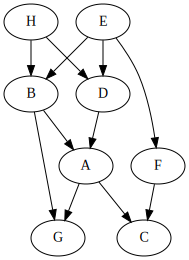

In [5]:
testgraph.visualise()

I've modified the test case from the original problem. I've added a second leaf dependency, G, as well as a second root dependant, H. This complicates the graph, and tests edge cases in the code.

Here is the merge function. It takes two resolution order strings, and returns the merged version.

In [27]:
def merge_ro(ro1, ro2):
    ro = ''
    while ro1 and ro2:
        if ro1[0] == ro2[0]:
            ro += ro1[0]
            ro1, ro2 = ro1[1:], ro2[1:]
        elif ro1[0] < ro2[0]:
            ro += ro1[0]
            ro1 = ro1[1:]
        else:  # ro1[0] > ro2[0]
            ro += ro2[0]
            ro2 = ro2[1:]
    # If ro1 and ro2 were of different lengths, add the remainder
    ro += ro1 + ro2
    return ro

In [28]:
merge_ro("CF", "CGAD")

'CFGAD'

In [25]:
from functools import reduce
def solve_ro(graph):
    sub_ros = {}
    def build_ro(node):
        if node not in sub_ros:
            ros = []
            for dep in graph[node]:
                ros.append(build_ro(dep))
            dep_ro = reduce(merge_ro, ros, '')
            sub_ros[node] = dep_ro + node
        return sub_ros[node]
    root_ros = []
    for root in graph.roots():
        root_ros.append(build_ro(root))
    return reduce(merge_ro, root_ros, '')

In [26]:
solve_ro(testgraph)

'CFGABDEH'

This looks very promising! It correctly solves the more complicated test input. 

In [16]:
graph = build_graph(read_input("input.txt"))

In [17]:
solve_ro(graph)

'CFGHAEMNBPRDISVWQUZJYTKLOX'

Success!